In [1]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os
from pprint import pprint

import pickle

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS

import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

In [2]:
def generate_gridsearch(model, X, y, params, train_size=.8):
    
    X_train, X_test, y_train, y_test = train_test_split(
         X,
         y,
         train_size=train_size,
         random_state=42
    )
    
    gscv = GridSearchCV(model, params, cv=5)
    gscv.fit(X_train, y_train)
    preds = gscv.predict(X_test)
    train_preds = gscv.predict(X_train)
    
    errors = preds - y_test
    
    print('Mean error %: ', abs(errors).mean())
    print('Mean error raw: ', abs(errors).mean() * 4)
    print('Best score: ', gscv.best_score_)
    print('Best params: ', gscv.best_params_)
    print('test rfr r^2: ', gscv.best_estimator_.score(X_test, y_test))
    print('train rfr r^2: ', gscv.best_estimator_.score(X_train, y_train))
    
    sns.scatterplot(
        x=preds,
        y=y_test
    )    
    sns.lineplot(
        x=y,
        y=y
    )
    sns.scatterplot(
    x=train_preds,
    y=y_train
    )
    plt.xlabel('predictions')
    plt.ylabel('actual')
    plt.plot()
    
    return gscv.best_estimator_

In [3]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/pre_survey.csv'
pre_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/post_survey.csv'
post_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/avg_survey.csv'
avg_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon.csv'
latlon = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/convos.csv'
convo = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/education/grades.csv'
grades = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/gps.csv'
gps = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/latlon_kmeans.csv'
latlon_kmeans = pd.read_csv(path)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
latlon.columns

Index(['uid', 'overnight_primary_bld', 'overnight_primary_type',
       'overnight_secondary_bld', 'overnight_secondary_type',
       'daytime_primary_bld', 'daytime_primary_type', 'daytime_secondary_bld',
       'daytime_secondary_type', 'daytime_tertiary_bld',
       'daytime_tertiary_type', 'overnight_primary_cluster',
       'overnight_secondary_cluster', 'daytime_primary_cluster',
       'daytime_secondary_cluster', 'daytime_tertiary_cluster'],
      dtype='object')

In [5]:
# Stripping 'u' from id in uid column in grades df
grades.uid = grades.uid.str.extract('(\d\d)').astype(int)

# Renaming grades columns
grades.columns = grades.columns.str.strip().str.replace(' ', '_')

# GPA Prediction

In [6]:
convo_copy = convo.copy()

data = convo_copy.merge(grades, on='uid', how='inner'
           ).merge(latlon, on='uid', how='inner')

In [7]:
latlon_vars = [
   'overnight_primary_bld', 'overnight_primary_type',
   'overnight_secondary_bld', 'overnight_secondary_type',
   'daytime_primary_bld', 'daytime_primary_type', 'daytime_secondary_bld',
   'daytime_secondary_type', 'daytime_tertiary_bld',
   'daytime_tertiary_type', 'daytime_tertiary_type'
    ]


latlon_dummies = pd.get_dummies(
    data[latlon_vars]
)


data = data.merge(latlon_dummies, right_index=True, left_index=True)

(array([ 2.,  0.,  1.,  0.,  0.,  3.,  0.,  7.,  3., 14.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

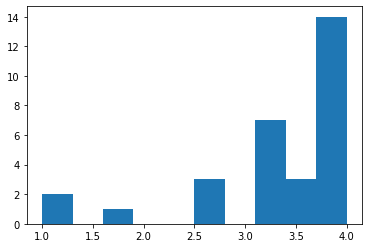

In [8]:
plt.hist(data.gpa_13s)

In [9]:
data.gpa_13s = mstats.winsorize(data.gpa_13s, (.1, 0))

In [10]:
len(data) * .95

28.5

In [11]:
print([col for col in data.columns[:20]])

['uid', 'avg_length', 'num', 'total_min', 'diff_avg_length', 'diff_num', 'diff_total_min', 'kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'gpa_all', 'gpa_13s', 'cs_65', 'overnight_primary_bld', 'overnight_primary_type', 'overnight_secondary_bld', 'overnight_secondary_type', 'daytime_primary_bld']


In [12]:
data[['gpa_13s', 'cs_65', 'gpa_all', 'avg_length', 'num']].corr()

,gpa_13s,cs_65,gpa_all,avg_length,num
gpa_13s,1.000000,0.515109,0.595979,-0.089221,0.080671
cs_65,0.515109,1.000000,0.527970,0.233026,0.212320
gpa_all,0.595979,0.527970,1.000000,-0.153381,0.336822
avg_length,-0.089221,0.233026,-0.153381,1.000000,-0.359791
num,0.080671,0.212320,0.336822,-0.359791,1.000000


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.14814814858333358
Mean error raw:  0.5925925943333343
Best score:  -0.32471096739674377
Best params:  {'leaf_size': 1, 'n_neighbors': 6}
test rfr r^2:  0.6063052661888404
train rfr r^2:  0.2055503480377494
CPU times: user 553 ms, sys: 21.3 ms, total: 574 ms
Wall time: 638 ms


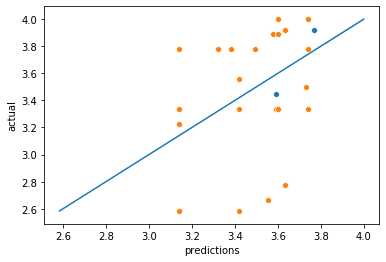

In [13]:
%%time
# K-Nearest Neighbor Regression


params = {'n_neighbors': [6],
          'leaf_size': [1]}

knn = generate_gridsearch(
    KNeighborsRegressor(),
    data[['avg_length', 'gpa_all']],
    data.gpa_13s,
    params,
    train_size=.95
)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.2825925929666697
Mean error raw:  1.1303703718666789
Best score:  -0.5266903733711145
Best params:  {'max_depth': 10, 'n_estimators': 150}
test rfr r^2:  -0.43965551614928766
train rfr r^2:  0.8254259514402242
CPU times: user 2.02 s, sys: 49.8 ms, total: 2.07 s
Wall time: 2.18 s


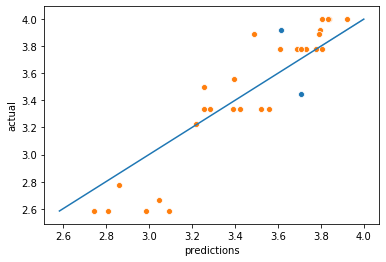

In [14]:
%%time
# Random Forest Regressor on 'num' and 'gpa_all'

params = {'n_estimators': [150],
          'max_depth': [10]}

rfr = generate_gridsearch(
    RandomForestRegressor(random_state=42),
    data[['num', 'gpa_all']],
    data.gpa_13s,
    params,
    train_size=.95
)

In [15]:
%%time
# Random Forest Regressor on 'num' and 'avg_length'

params = {'n_estimators': [200],
          'max_depth': [9]}

rfr = generate_gridsearch(
    data[['avg_length', 'num']],
    data.gpa_13s,
    params,
    train_size=.95
)

TypeError: generate_gridsearch() missing 1 required positional argument: 'params'

(array([1., 1., 1., 1., 2., 3., 3., 3., 2., 1., 4., 2., 0., 2., 2., 1., 0.,
        0., 0., 1.]),
 array([ 5.96273506,  6.46085326,  6.95897147,  7.45708967,  7.95520787,
         8.45332607,  8.95144428,  9.44956248,  9.94768068, 10.44579888,
        10.94391708, 11.44203529, 11.94015349, 12.43827169, 12.93638989,
        13.4345081 , 13.9326263 , 14.4307445 , 14.9288627 , 15.4269809 ,
        15.92509911]),
 <a list of 20 Patch objects>)

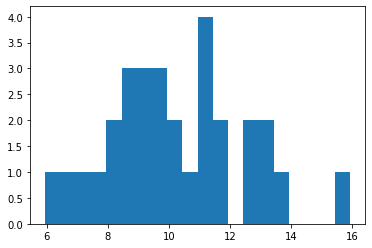

In [16]:
plt.hist(data.avg_length / 66, bins=20)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.11941658404785323
Mean error raw:  0.4776663361914129
Best score:  -1.055722693671828
Best params:  {'learning_rate': 0.05, 'n_estimators': 70}
test rfr r^2:  0.6004937555415341
train rfr r^2:  0.9227362767813067


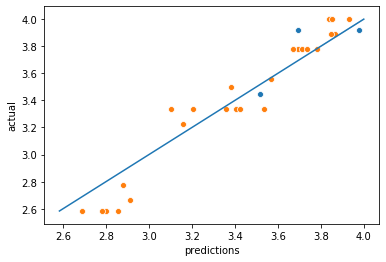

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.13405129383766448
Mean error raw:  0.5362051753506579
Best score:  -1.121472279509725
Best params:  {'learning_rate': 0.1, 'n_estimators': 70}
test rfr r^2:  0.5307293188084891
train rfr r^2:  0.9893675321028265


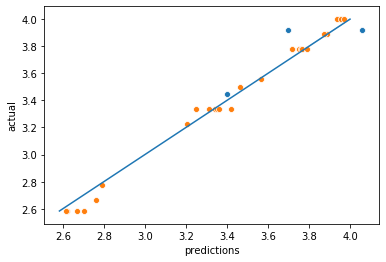

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.19416990611809246
Mean error raw:  0.7766796244723698
Best score:  -1.1399893213224084
Best params:  {'learning_rate': 0.2, 'n_estimators': 70}
test rfr r^2:  -0.06746991153944881
train rfr r^2:  0.9998759154842166


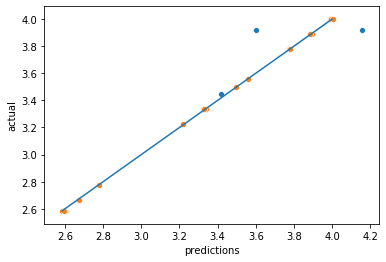

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.15642122509372003
Mean error raw:  0.6256849003748801
Best score:  -1.3795882896047098
Best params:  {'learning_rate': 0.3, 'n_estimators': 70}
test rfr r^2:  0.06861347990047195
train rfr r^2:  0.9999992960117982


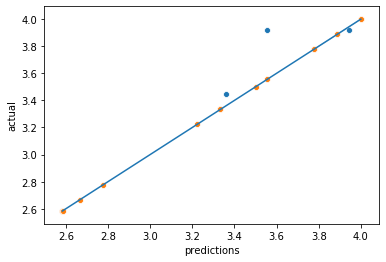

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean error %:  0.4574664621237778
Mean error raw:  1.8298658484951111
Best score:  -1.2470083474264262
Best params:  {'learning_rate': 0.7, 'n_estimators': 70}
test rfr r^2:  -4.02642515025085
train rfr r^2:  0.9999996117620628


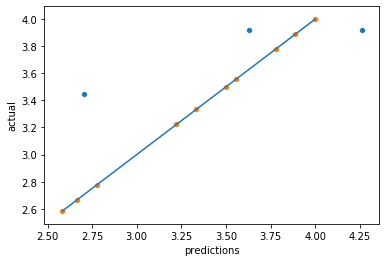

CPU times: user 3.65 s, sys: 105 ms, total: 3.76 s
Wall time: 3.79 s


In [17]:
%%time
# Gradient Boosting Regressor

for i in [.05, .1, .2, .3, .7]:
    params = {'n_estimators': [70],
              'learning_rate': [i]}
    gbr = generate_gridsearch(
        GradientBoostingRegressor(random_state=42),
        data[['avg_length', 'gpa_all']],
        data.gpa_13s,
        params,
        train_size=.90
    )
    plt.show()

With the higher learning rates, we're beginning to see overfitting. This is clear first of all because our r-squared for the training set is nearing in on 100%, but the r-squared for the test set is nearing zero or becoming negative. We see the same thing with the visualization, where as the training set (in orange) approaches more and more closely the line of "perfect prediction", the test set (in blue) goes further away.

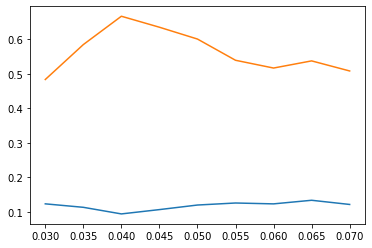

CPU times: user 447 ms, sys: 9.06 ms, total: 456 ms
Wall time: 470 ms


In [18]:
%%time
# Gradient Boosting Regressor

learning_rates = np.arange(.03, .07, .005)

mean_errors = []
test_r2s = []

X_train, X_test, y_train, y_test = train_test_split(
     data[['avg_length', 'gpa_all']],
     data.gpa_13s,
     train_size=.9,
     random_state=42
)

for i in learning_rates:
    
    gbr = GradientBoostingRegressor(
        random_state=42,
        n_estimators=70,
        learning_rate=i
    )
    gbr.fit(X_train, y_train)
    preds = gbr.predict(X_test)
    train_preds = gbr.predict(X_train)
    
    errors = preds - y_test
    
    mean_errors.append(abs(errors).mean())
    test_r2s.append(gbr.score(X_test, y_test))

sns.lineplot(
    x=learning_rates,
    y=mean_errors
)
sns.lineplot(
    x=learning_rates,
    y=test_r2s
)
plt.show()

A learning rate of .04 is our best bet!

Mean error %:  0.09198579301270964
Mean error raw:  0.36794317205083854
Best score:  -0.9581120755349578
Best params:  {'criterion': 'mse', 'learning_rate': 0.04, 'max_depth': 3, 'min_impurity_decrease': 5e-05, 'n_estimators': 70}
test rfr r^2:  0.6734508548589119
train rfr r^2:  0.8838491044861808


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 493 ms, sys: 21.7 ms, total: 515 ms
Wall time: 511 ms


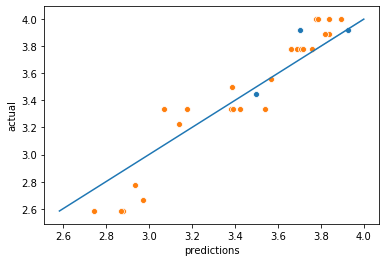

In [19]:
%%time
params = {'n_estimators': [70],
          'learning_rate': [.04],
          'max_depth': [3],
          'criterion': ['mse'],
          'min_impurity_decrease': [.00005]}

gbr = generate_gridsearch(
    GradientBoostingRegressor(random_state=42),
    data[['avg_length', 'gpa_all']],
    data.gpa_13s,
    params,
    train_size=.9
)

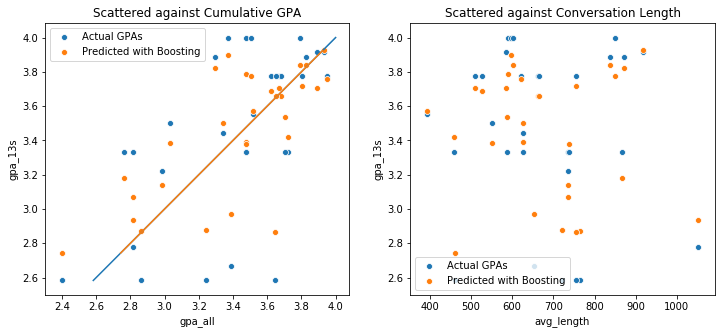

In [20]:
preds = gbr.predict(data[['avg_length', 'gpa_all']])


plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(
    x=data['gpa_all'],
    y=data.gpa_13s,
    label='Actual GPAs'
)
sns.lineplot(
    x=data.gpa_13s,
    y=data.gpa_13s
)
sns.scatterplot(
    x=data['gpa_all'],
    y=preds,
    label='Predicted with Boosting'
)
sns.lineplot(
    x=preds,
    y=preds
)
plt.legend()
plt.title('Scattered against Cumulative GPA')

plt.subplot(122)
sns.scatterplot(
    x=data['avg_length'],
    y=data.gpa_13s,
    label='Actual GPAs'
)
sns.scatterplot(
    x=data['avg_length'],
    y=preds,
    label='Predicted with Boosting'
)

plt.legend()
plt.title('Scattered against Conversation Length')

plt.show()

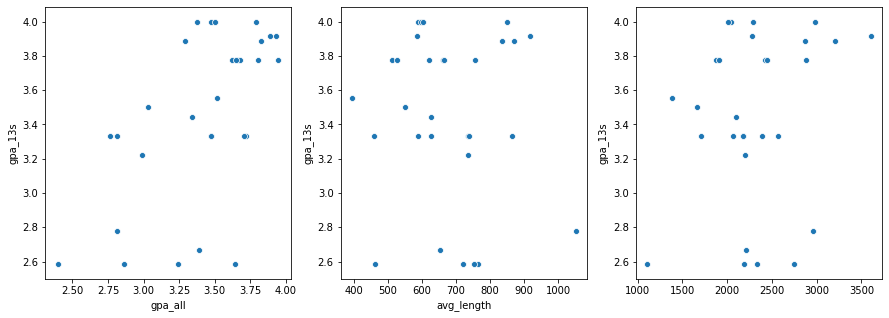

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.scatterplot(
    x=data.gpa_all,
    y=data.gpa_13s
)
plt.subplot(132)
sns.scatterplot(
    x=data.avg_length,
    y=data.gpa_13s
)
plt.subplot(133)
sns.scatterplot(
    x=data.avg_length * data.gpa_all,
    y=data.gpa_13s
)

# Dash Web App

In [22]:
pickle.dump(gbr, open("gbr_avglength_gpa.py", "wb"))

file = open("gbr_avglength_gpa.py", 'rb')
gbr_pickle = pickle.load(file)

In [23]:
gbr_pickle.score(
    data[['avg_length', 'gpa_all']], data.gpa_13s)

0.8843667993065024

In [24]:
# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# app.layout = html.Div([
#     html.H6("What is your current cumulative GPA?"),
#     html.Div([dcc.Input(id='my-input', value='', type='text')]),
#     html.H6("How long would you say these conversations are usually? Most conversations are about ten minutes, give or take a couple minutes."),
#     dcc.Slider(
#         id='length--slider',
#         min=data.avg_length.min(),
#         max=data.avg_length.max(),
#         value=data.avg_length.min(),
#         marks={length: str(round(length / 66, 1)) for length in
#                np.arange(data.avg_length.min(), data.avg_length.max(),
#                          (data.avg_length.max() - data.avg_length.min()) / 12
#                         )
#               },
#         step=None
#     ),
#     html.Br(),
#     html.Div(id='my-output'),

# ])


# @app.callback(
#     Output(component_id='my-output', component_property='children'),
#     [Input(component_id='my-input', component_property='value'),
#      Input(component_id='length--slider', component_property='value')]
# )  
# def update_output_div(my_input, length_value):
#     pred = gbr_pickle.predict(
#         np.array([float(length_value), my_input]).reshape(1,-1)
#     )
#     pred = round(pred[0], 2)
#     return 'Your predicted spring GPA is: {}'.format(pred)


# if __name__ == '__main__':
#     app.run_server(mode='inline', debug=False)

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H6("What is your current cumulative GPA?"),
    dcc.Slider(
        id='gpa--slider',
        min=data.gpa_all.min(),
        max=data.gpa_all.max(),
        marks={round(gpa, 1): str(round(gpa,1)) for gpa in
               np.arange(2.5, 4, 0.1)
              },
        step=None
    ),
    html.H6("Would you say you have longer or shorter conversations on average? The average is 10 minutes."),
    dcc.Slider(
        id='length--slider',
        min=data.avg_length.min(),
        max=data.avg_length.max(),
        value=data.avg_length.min(),
        marks={length: str(round(length / 66, 1)) for length in
               np.arange(data.avg_length.min(), data.avg_length.max(), data.avg_length.std() /2 )
              },
        step=None
    ),
    html.Br(),
    html.Div(id='my-output'),

])


@app.callback(
    Output(component_id='my-output', component_property='children'),
    [Input(component_id='gpa--slider', component_property='value'),
     Input(component_id='length--slider', component_property='value')]
)  
def update_output_div(gpa_value, length_value):
    pred = gbr_pickle.predict(
        np.array([length_value, gpa_value]).reshape(1,-1)
    )
    pred = round(pred[0], 2)
    return 'Your predicted spring GPA is: {}'.format(pred)


if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Sep/2020 18:40:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:42] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:42] "GET /_dash-dependencies HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/opt/anaconda3/lib/python3.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/opt/anaconda3/lib/python3.7/site-packages/dash/dash.py", line 1050, in dispatch
    response.set_d

127.0.0.1 - - [17/Sep/2020 18:40:43] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [17/Sep/2020 18:40:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Sep/2020 18:40:54] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

fig = px.scatter(data, x="avg_length", y="gpa_13s")

fig = fig.update_layout(transition_duration=500,
                          yaxis=dict(range=[data.gpa_13s.min()-.1,
                                            data.gpa_13s.max()+.1]))

app.layout = html.Div([
        dcc.Graph(
        id='graph',
        figure=fig
    ),
    html.Br(),
    dcc.Slider(
        id='gpa--slider',
        min=data.gpa_all.min(),
        max=data.gpa_all.max(),
        value=data.avg_length.min(),
        marks={gpa: str(round(gpa,1)) for gpa in np.arange(2.5, 4, .1)},
        step=None
    )
])

@app.callback(
    Output(component_id='graph', component_property='figure'),
    [Input(component_id='gpa--slider', component_property='value')]
)  
def update_figure(gpa_value):
    filtered_df = data[(data.gpa_all > gpa_value - .25) &
                       (data.gpa_all < gpa_value + .25)]

    fig = px.scatter(filtered_df, x="avg_length", y="gpa_13s")

    return fig


if __name__ == '__main__':
    app.run_server(mode='inline', debug=False)

# Mental Health Prediction

In [ ]:
data = convo.merge(post_survey, on='uid', how='inner')

latlon_dummies = pd.get_dummies(
    latlon[[
   'overnight_primary_bld', 'overnight_primary_type',
   'overnight_secondary_bld', 'overnight_secondary_type',
   'daytime_primary_bld', 'daytime_primary_type', 'daytime_secondary_bld',
   'daytime_secondary_type', 'daytime_tertiary_bld',
   'daytime_tertiary_type', 'overnight_primary_cluster',
   'overnight_secondary_cluster', 'daytime_primary_cluster',
   'daytime_secondary_cluster', 'daytime_tertiary_cluster'
    ]]
)

data = pd.concat([data, latlon_dummies], axis=1)

data = data.merge(grades[['uid', 'gpa_13s']], on='uid', how='right').dropna()

In [ ]:
not_in_X_vars = [
    'uid','panas_pos_avg', 'panas_pos_sum', 'panas_neg_avg', 'panas_neg_sum',
    'panas_net_avg', 'panas_net_sum', 'flourishing_avg', 'flourishing_sum',
    'depression_avg', 'depression_sum', 'stress_avg', 'stress_sum', 'loneliness_avg',
    'loneliness_sum', 'overnight_primary_cluster', 'overnight_secondary_cluster',
    'daytime_primary_cluster', 'daytime_secondary_cluster', 'daytime_tertiary_cluster'
]

X = data.drop(columns=not_in_X_vars)

y = data.depression_sum

In [ ]:
%%time
params = {'n_estimators': [194]}

depr_rfr = generate_gridsearch(X, y, params)